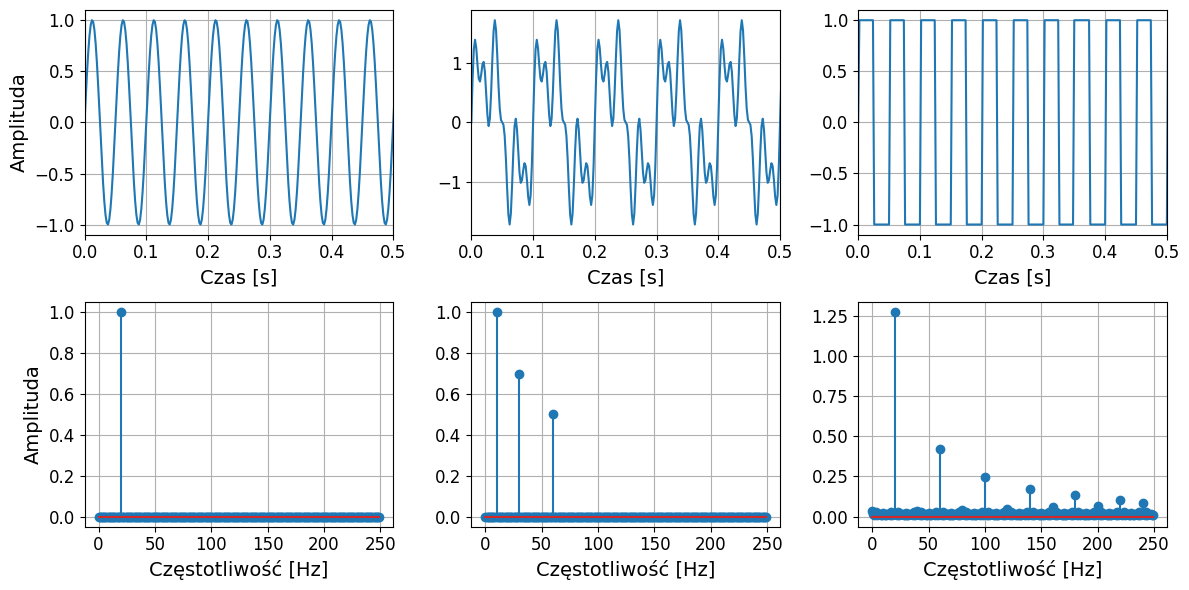

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Parametry sygnałów
fs = 500        # częstotliwość próbkowania [Hz]
T = 1.0         # czas trwania [s]
t = np.linspace(0, T, int(fs*T), endpoint=False)

# 1) Sygnał sinusoidalny 20 Hz
x1 = np.sin(2 * np.pi * 20 * t)

# 2) Suma trzech różnych sinusów
x2 = (1.0 * np.sin(2 * np.pi * 10 * t) +
      0.7 * np.sin(2 * np.pi * 30 * t) +
      0.5 * np.sin(2 * np.pi * 60 * t))

# 3) Sygnał prostokątny 20 Hz
x3 = np.sign(np.sin(2 * np.pi * 20 * t))

def compute_fft(x, fs):
    N = len(x)
    X = np.fft.fft(x)
    freqs = np.fft.fftfreq(N, d=1.0/fs)
    idx = freqs >= 0
    freqs_pos = freqs[idx]
    X_amp = (2.0 / N) * np.abs(X[idx])
    return freqs_pos, X_amp

# Obliczenie widm
f1, X1 = compute_fft(x1, fs)
f2, X2 = compute_fft(x2, fs)
f3, X3 = compute_fft(x3, fs)

# Tworzenie wykresów 3x2
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

# Ustawienia czcionek
label_font = 14
tick_font = 12

# --------- 1. wiersz: sygnały w dziedzinie czasu ---------
# Ustal zakres czasu do wyświetlenia (np. 0–0.1 s)
time_window = (0, 0.5)

# Sinus 20 Hz
axes[0, 0].plot(t, x1)
axes[0, 0].set_xlim(time_window)
axes[0, 0].set_xlabel("Czas [s]", fontsize=label_font)
axes[0, 0].set_ylabel("Amplituda", fontsize=label_font)
axes[0, 0].tick_params(labelsize=tick_font)
axes[0, 0].grid(True)

# Suma trzech sinusów
axes[0, 1].plot(t, x2)
axes[0, 1].set_xlim(time_window)
axes[0, 1].set_xlabel("Czas [s]", fontsize=label_font)
#axes[0, 1].set_ylabel("Amplituda", fontsize=label_font)
axes[0, 1].tick_params(labelsize=tick_font)
axes[0, 1].grid(True)

# Prostokąt 20 Hz
axes[0, 2].plot(t, x3)
axes[0, 2].set_xlim(time_window)
axes[0, 2].set_xlabel("Czas [s]", fontsize=label_font)
#axes[0, 2].set_ylabel("Amplituda", fontsize=label_font)
axes[0, 2].tick_params(labelsize=tick_font)
axes[0, 2].grid(True)

# --------- 2. wiersz: widma częstotliwości ---------
f_max = 250

# Widmo sinusa 20 Hz
axes[1, 0].stem(f1[f1 <= f_max], X1[f1 <= f_max])
axes[1, 0].set_xlabel("Częstotliwość [Hz]", fontsize=label_font)
axes[1, 0].set_ylabel("Amplituda", fontsize=label_font)
axes[1, 0].tick_params(labelsize=tick_font)
axes[1, 0].grid(True)

# Widmo sumy 3 sinusów
axes[1, 1].stem(f2[f2 <= f_max], X2[f2 <= f_max])
axes[1, 1].set_xlabel("Częstotliwość [Hz]", fontsize=label_font)
#axes[1, 1].set_ylabel("Amplituda", fontsize=label_font)
axes[1, 1].tick_params(labelsize=tick_font)
axes[1, 1].grid(True)

# Widmo prostokąta 20 Hz
axes[1, 2].stem(f3[f3 <= f_max], X3[f3 <= f_max])
axes[1, 2].set_xlabel("Częstotliwość [Hz]", fontsize=label_font)
#axes[1, 2].set_ylabel("Amplituda", fontsize=label_font)
axes[1, 2].tick_params(labelsize=tick_font)
axes[1, 2].grid(True)

plt.tight_layout()
plt.show()


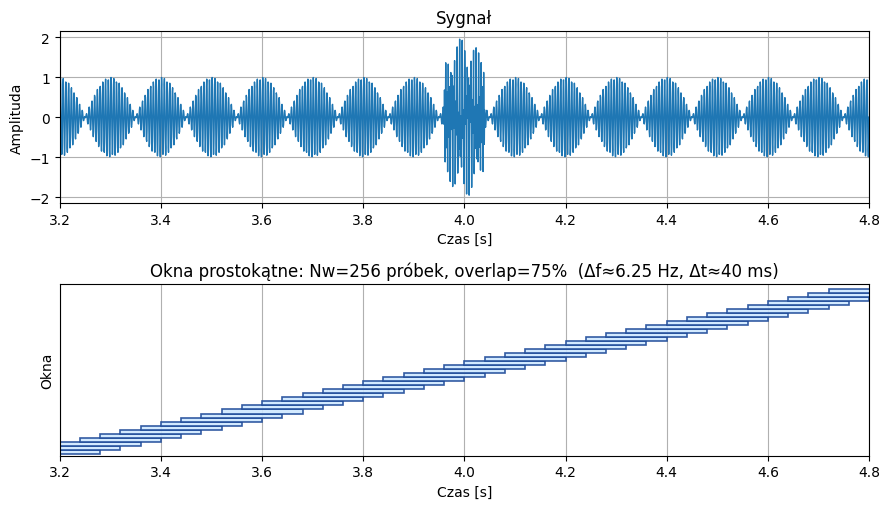

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# --- Parametry sygnału i STFT ---
fs = 1600.0               # [Hz]
T = 6.0                   # [s]
Nw = 256                  # długość okna [próbki] (krótkie okno)
overlap = 0.75            # nakładanie (75%)
hop = int(Nw * (1.0 - overlap))   # krok w próbkach
zoom_t0, zoom_t1 = 3.2, 4.8       # zakres zoomu [s]

# --- Generacja sygnału demo: 180/190 Hz + krótki burst 400 Hz ---
t = np.arange(0, T, 1.0/fs)
x = 0.5*np.sin(2*np.pi*180.0*t) + 0.5*np.sin(2*np.pi*190.0*t)
burst_center, burst_dur = 4.0, 0.08
mask_burst = ((t >= burst_center - burst_dur/2) & (t <= burst_center + burst_dur/2)).astype(float)
x += 1.0*np.sin(2*np.pi*400.0*t) * mask_burst

# --- Wyznaczenie centrów okien, które mieszczą się w [zoom_t0, zoom_t1] ---
centers = []
n = max(Nw // 2, int(np.floor(zoom_t0 * fs / hop)) * hop)   # start tak, by okno było pełne
while (n - Nw//2) >= 0 and (n + Nw//2) < len(t) and (n/fs) <= zoom_t1:
    centers.append(n)
    n += hop
centers = np.array(centers, dtype=int)

# --- Rysunek: 2 subplota ---
fig, axes = plt.subplots(2, 1, figsize=(9, 5.2), sharex=False)

# (1) Sygnał w powiększeniu
mask_zoom = (t >= zoom_t0) & (t <= zoom_t1)
axes[0].plot(t[mask_zoom], x[mask_zoom], linewidth=1.0)
axes[0].set_xlim(zoom_t0, zoom_t1)
axes[0].set_title('Sygnał')
axes[0].set_xlabel('Czas [s]')
axes[0].set_ylabel('Amplituda')
axes[0].grid(True)

# (2) „Schodki” z prostokątnymi oknami (niebieskie wypełnienie + ciemnoniebieski kontur)
ax = axes[1]
for i, c in enumerate(centers):
    left = (c - Nw//2) / fs          # [s]
    width = Nw / fs                  # [s]
    rect = Rectangle(
        (left, i), width, 1.0,
        facecolor='#cfe8ff',   # jasny niebieski wypełnienia
        edgecolor='#1f4b99',   # ciemniejszy niebieski kontur
        alpha=0.9,             # delikatna przezroczystość (opcjonalnie)
        linewidth=1.2,
        zorder=2
    )
    ax.add_patch(rect)

ax.set_xlim(zoom_t0, zoom_t1)
ax.set_ylim(-0.5, len(centers) + 1.2)
ax.set_xlabel('Czas [s]')
ax.set_ylabel('Okna')
ax.set_yticks([])
df = fs / Nw
dt = hop / fs
ax.set_title(f'Okna prostokątne: Nw={Nw} próbek, overlap={int(overlap*100)}%  (Δf≈{df:.2f} Hz, Δt≈{dt*1000:.0f} ms)')
ax.grid(True, axis='x')

plt.tight_layout()
plt.show()


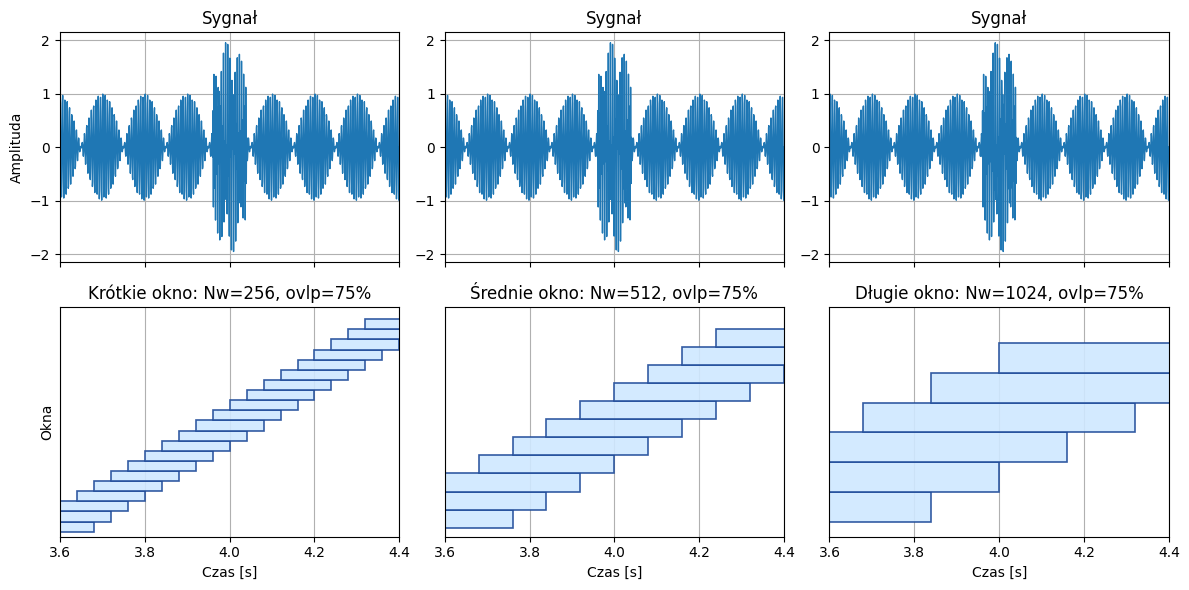

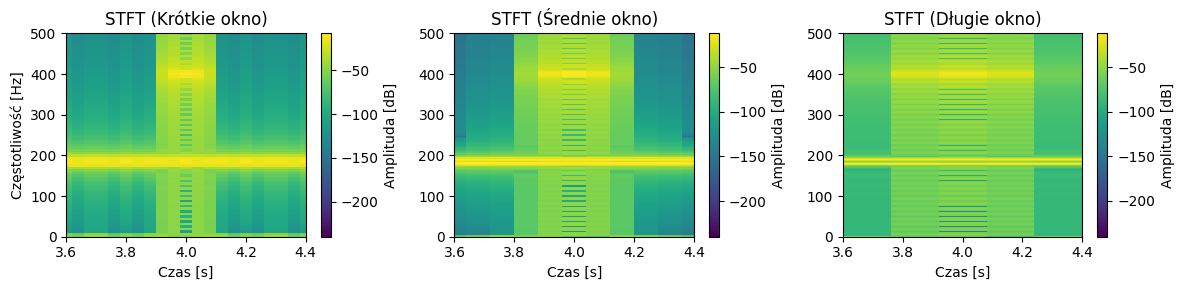

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.signal import spectrogram, get_window

# --- Parametry globalne ---
fs = 1600.0
T  = 6.0
zoom_t0, zoom_t1 = 3.6, 4.4
overlap = 0.75  # 75%

# długości okien: krótkie / średnie / długie
Nw_short = 256
Nw_mid   = 512
Nw_long  = 1024

# --- sygnał demo: 180/190 Hz + krótki burst 400 Hz ---
t = np.arange(0, T, 1.0/fs)
x = 0.5*np.sin(2*np.pi*180.0*t) + 0.5*np.sin(2*np.pi*190.0*t)
burst_center, burst_dur = 4.0, 0.08
mask_burst = ((t >= burst_center - burst_dur/2) & (t <= burst_center + burst_dur/2)).astype(float)
x += 1.0*np.sin(2*np.pi*400.0*t) * mask_burst
mask_zoom = (t >= zoom_t0) & (t <= zoom_t1)

# --- pomocnicza: centra ramek w [zoom_t0, zoom_t1] ---
def compute_centers(Nw, overlap, t0, t1):
    hop = int(Nw * (1.0 - overlap))
    centers = []
    n = max(Nw // 2, int(np.floor(t0 * fs / hop)) * hop)
    while (n - Nw//2) >= 0 and (n + Nw//2) < len(t) and (n/fs) <= t1:
        centers.append(n)
        n += hop
    return np.array(centers, dtype=int), hop

# =========================================================
# FIGURA A: 2 x 3 (u góry sygnał; u dołu okna krótkie/średnie/długie)
# =========================================================
figA, axesA = plt.subplots(2, 3, figsize=(12, 6), sharex='col')

# Dane dla trzech kolumn
Nw_list   = [Nw_short, Nw_mid, Nw_long]
titles    = ['Krótkie okno', 'Średnie okno', 'Długie okno']

for j, (Nw, ttl) in enumerate(zip(Nw_list, titles)):
    # (góra) sygnał (zoom)
    axesA[0, j].plot(t[mask_zoom], x[mask_zoom], linewidth=1.0)
    axesA[0, j].set_title('Sygnał')
    axesA[0, j].grid(True)
    axesA[0, j].set_xlim(zoom_t0, zoom_t1)
    if j == 0:
        axesA[0, j].set_ylabel('Amplituda')

    # (dół) schodki z prostokątnymi oknami
    centers, hop = compute_centers(Nw, overlap, zoom_t0, zoom_t1)
    ax = axesA[1, j]
    for i, c in enumerate(centers):
        left  = (c - Nw//2) / fs
        width = Nw / fs
        rect = Rectangle(
            (left, i), width, 1.0,
            facecolor='#cfe8ff', edgecolor='#1f4b99',
            alpha=0.9, linewidth=1.2, zorder=2
        )
        ax.add_patch(rect)

    ax.set_xlim(zoom_t0, zoom_t1)
    ax.set_ylim(-0.5, len(centers) + 1.2)
    ax.set_yticks([])
    df = fs / Nw
    dt = hop / fs
    ax.set_title(f'{ttl}: Nw={Nw}, ovlp=75%')
    ax.set_xlabel('Czas [s]')
    if j == 0:
        ax.set_ylabel('Okna')
    ax.grid(True, axis='x')

plt.tight_layout()
plt.show()

# =========================================================
# FIGURA B: 1 x 3 (STFT dla krótkiego / średniego / długiego okna)
# =========================================================
figB, axesB = plt.subplots(1, 3, figsize=(12, 3), sharex=False)

for j, (Nw, ttl) in enumerate(zip(Nw_list, titles)):
    win = get_window('hann', Nw, fftbins=True)
    f, tt, S = spectrogram(x, fs=fs, window=win, nperseg=Nw,
                           noverlap=int(Nw*overlap), scaling='spectrum', mode='magnitude')
    S_db = 20*np.log10(S + 1e-12)
    im = axesB[j].pcolormesh(tt, f, S_db, shading='auto')
    axesB[j].set_ylim(0, 500)
    axesB[j].set_xlim(zoom_t0, zoom_t1)
    axesB[j].set_title(f'STFT ({ttl})')
    axesB[j].set_xlabel('Czas [s]')
    if j == 0:
        axesB[j].set_ylabel('Częstotliwość [Hz]')
    cbar = plt.colorbar(im, ax=axesB[j])
    cbar.set_label('Amplituda [dB]')

plt.tight_layout()
plt.show()


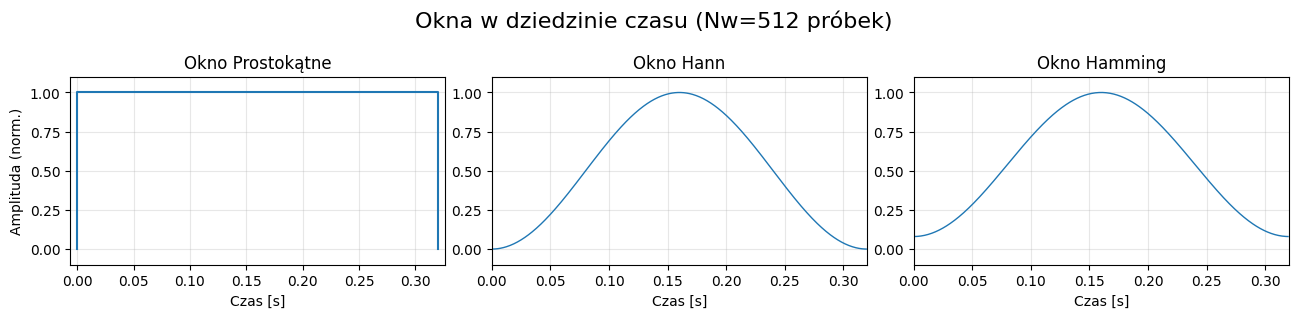

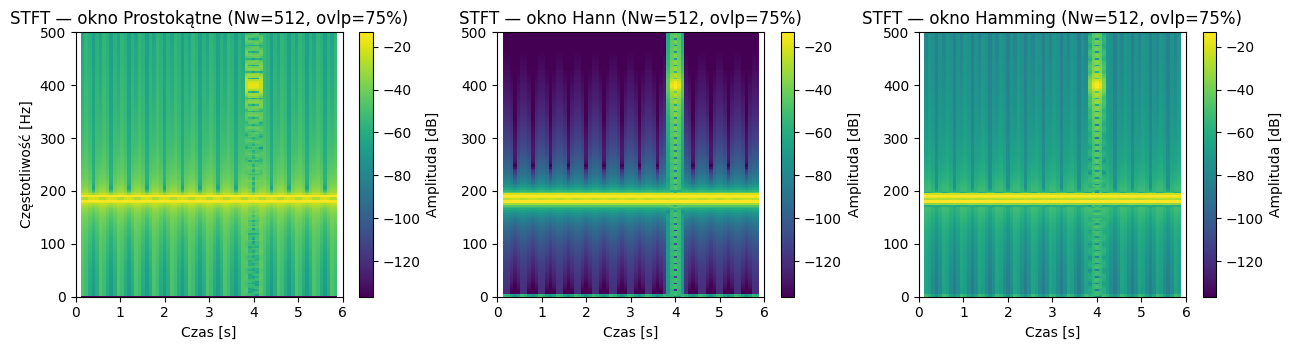

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import get_window, spectrogram

# ===================== USTAWIENIA =====================
fs = 1600.0                 # [Hz]
T  = 6.0                    # [s]
overlap = 0.75              # 75% dla STFT
zoom_t0, zoom_t1 = 0, 6 # zakres czasu na wykresach
Nw = 512                    # stała długość okna dla porównań

# Okna do porównania (etykieta, klucz w get_window)
windows = [
    ('Prostokątne', 'boxcar'),
    ('Hann',        'hann'),
    ('Hamming',     'hamming'),
]

# ===================== SYGNAŁ DEMO =====================
t = np.arange(0, T, 1.0/fs)
x = 0.5*np.sin(2*np.pi*180.0*t) + 0.5*np.sin(2*np.pi*190.0*t)
burst_center, burst_dur = 4.0, 0.08
mask_burst = ((t >= burst_center - burst_dur/2) & (t <= burst_center + burst_dur/2)).astype(float)
x += 1.0*np.sin(2*np.pi*400.0*t) * mask_burst
mask_zoom = (t >= zoom_t0) & (t <= zoom_t1)

# ===================== FIGURA A: 1×3 – OKNA W DZIEDZINIE CZASU =====================
figA, axesA = plt.subplots(1, 3, figsize=(13, 3.2), sharex=False)
figA.suptitle('Okna w dziedzinie czasu (Nw=512 próbek)', fontsize=16)

for j, (label, key) in enumerate(windows):
    ax = axesA[j]
    if key == 'boxcar':
        # PRZEBIEG PROSTOKĄTNY: poziom 0 → 1 → 1 → 0 z wyraźnymi krawędziami
        dur = Nw / fs
        x_step = [0.0, 0.0, dur,  dur]   # czas
        y_step = [0.0, 1.0, 1.0, 0.0]    # amplituda
        ax.plot(x_step, y_step, linewidth=1.5, drawstyle='default')
        ax.set_xlim(-0.02*dur, 1.02*dur)
        ax.set_ylim(-0.1, 1.1)
    else:
        # Hann / Hamming – przebieg próbki po próbce (znormalizowany do 1)
        w = get_window(key, Nw, fftbins=True).astype(float)
        w = w / (np.max(np.abs(w)) + 1e-12)
        n = np.arange(Nw) / fs
        ax.plot(n, w, linewidth=1.0)
        ax.set_xlim(0, Nw/fs)
        ax.set_ylim(-0.1, 1.1)

    ax.set_title(f'Okno {label}')
    ax.set_xlabel('Czas [s]')
    if j == 0:
        ax.set_ylabel('Amplituda (norm.)')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ===================== FIGURA B: 1×3 – SPEKTROGRAMY (Nw=512, różne okna) =====================
figB, axesB = plt.subplots(1, 3, figsize=(13, 3.6), sharex=False)

# Najpierw policzmy wspólny zakres dB (vmin/vmax) dla uczciwego porównania
specs = []
for label, key in windows:
    win = get_window(key, Nw, fftbins=True)
    f, tt, S = spectrogram(x, fs=fs, window=win, nperseg=Nw,
                           noverlap=int(Nw*overlap), scaling='spectrum', mode='magnitude')
    specs.append((label, f, tt, 20*np.log10(S + 1e-12)))

vals = []
for _, f, tt, S_db in specs:
    fmask = (f >= 0) & (f <= 500)
    tmask = (tt >= zoom_t0) & (tt <= zoom_t1)
    vals.append(S_db[np.ix_(fmask, tmask)])
all_vals = np.concatenate([v.ravel() for v in vals])
vmin = np.percentile(all_vals, 5)
vmax = np.percentile(all_vals, 99)

for ax, (label, f, tt, S_db) in zip(axesB, specs):
    im = ax.pcolormesh(tt, f, S_db, shading='auto', vmin=vmin, vmax=vmax)
    ax.set_ylim(0, 500)
    ax.set_xlim(zoom_t0, zoom_t1)
    ax.set_title(f'STFT — okno {label} (Nw={Nw}, ovlp=75%)')
    ax.set_xlabel('Czas [s]')
    if ax is axesB[0]:
        ax.set_ylabel('Częstotliwość [Hz]')
    cbar = plt.colorbar(im, ax=ax); cbar.set_label('Amplituda [dB]')

plt.tight_layout()
plt.show()
